<a href="https://colab.research.google.com/github/carloslme/ds-portfolio/blob/main/predictive-analytics/predictive_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Predictive Analytics is a process of statistical techniques derived from data mining, machine learning and predictive modeling that obtain current and historical events to predict future events or unknown outcomes in the future.

The goal of this exercise is to build a machine learning pipeline for predictive analytics using this open dataset: https://datos.cdmx.gob.mx/dataset/incidentes-viales-c5, which shows the road incidents in Mexico City during february 2021 in the 16 town halls.

# Setup

In [23]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Data Ingestion

## Getting data from website 

In [2]:
!pip install requests

In [3]:
import requests

In [4]:
res = requests.get('https://datos.cdmx.gob.mx/dataset/a6d1d483-65d2-4ed9-9687-1932eb0cf70f/resource/c6b0fe65-137c-40d6-99c9-6c527f9b29c4/download/___')

In [5]:
res.raise_for_status()
csv_file = open('incidentes-viales-c5.csv', 'wb')
for chunk in res.iter_content(100000):
  csv_file.write(chunk)

csv_file.close()

# Data Exploration 

In [6]:
import pandas as pd

In [24]:
incidents = pd.read_csv('/content/incidentes-viales-c5.csv')
incidents.head()

,Unnamed: 0,folio,fecha_creacion,hora_creacion,dia_semana,fecha_cierre,hora_cierre,incidente_c4,delegacion_inicio,latitud,longitud,codigo_cierre,clas_con_f_alarma,tipo_entrada,delegacion_cierre,ano,mes
0,1,C5/210201/04663,01/02/2021,19:14:39,Lunes,01/02/2021,20:36:48,accidente-choque con lesionados,GUSTAVO A. MADERO,19.461570,-99.115210,A,URGENCIAS MEDICAS,LLAMADA DEL 911,GUSTAVO A. MADERO,2021,2
1,2,C5/210201/00391,01/02/2021,01:02:02,Lunes,01/02/2021,01:20:09,accidente-choque sin lesionados,GUSTAVO A. MADERO,19.471440,-99.081770,N,EMERGENCIA,LLAMADA DEL 911,GUSTAVO A. MADERO,2021,2
2,3,C5/210201/03815,01/02/2021,16:49:58,Lunes,01/02/2021,19:11:53,accidente-choque con lesionados,MIGUEL HIDALGO,19.440680,-99.190980,A,URGENCIAS MEDICAS,LLAMADA DEL 911,MIGUEL HIDALGO,2021,2
3,4,C5/210201/02068,01/02/2021,11:10:52,Lunes,01/02/2021,12:24:56,accidente-choque sin lesionados,COYOACAN,19.342580,-99.148890,A,EMERGENCIA,LLAMADA DEL 911,COYOACAN,2021,2
4,5,C5/210201/03832,01/02/2021,16:52:41,Lunes,01/02/2021,17:38:14,accidente-choque con lesionados,TLALPAN,19.200021,-99.138111,N,URGENCIAS MEDICAS,LLAMADA DEL 911,TLALPAN,2021,2


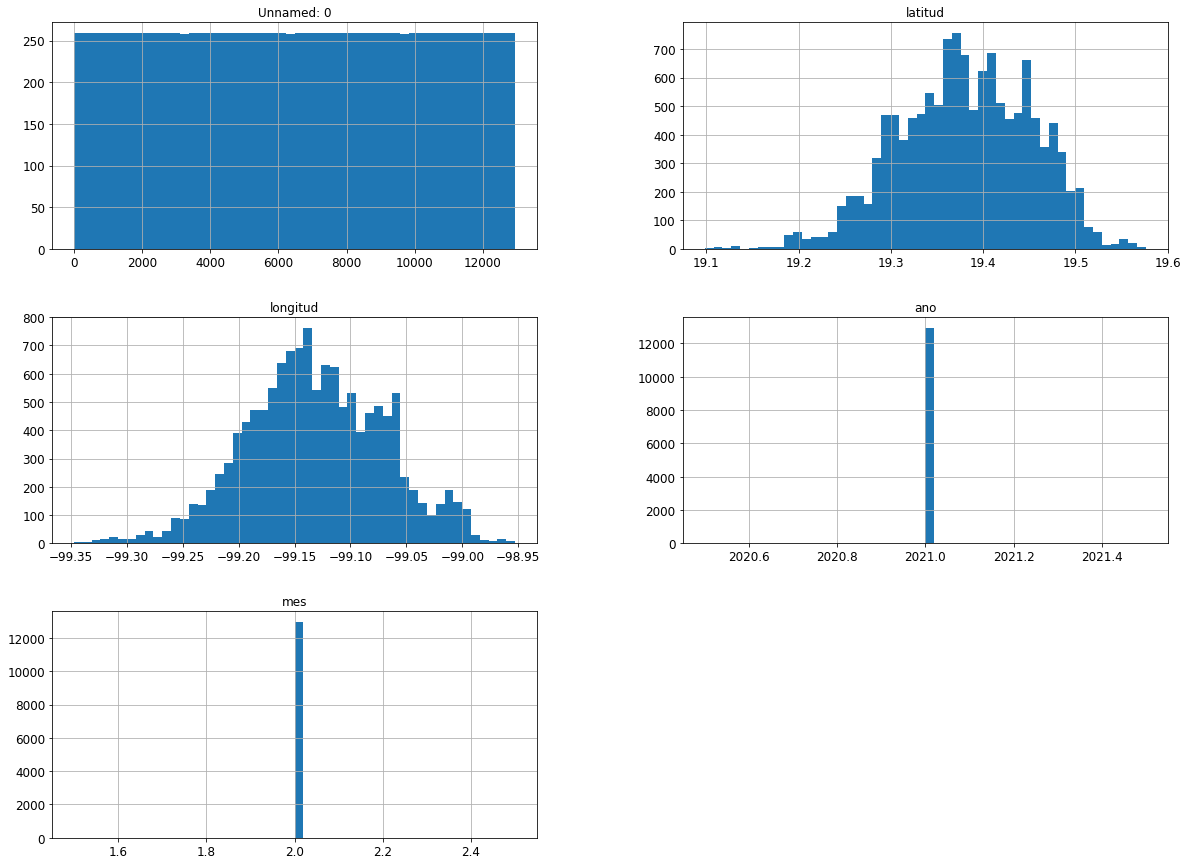

In [26]:
# Showing the number of instances (on the vertical axis) that have a given value range (on the horizontal axis)
%matplotlib inline
import matplotlib.pyplot as plt
incidents.hist(bins=50, figsize=(20,15))
plt.show()

# Data Preprocessing

## Data dictionary
Let's understand the meaning of each column. 

Original Data Dictionary can be found [here](https://datos.cdmx.gob.mx/dataset/a6d1d483-65d2-4ed9-9687-1932eb0cf70f/resource/49b5360c-5922-46bd-b4f8-ed0225d5ddbf/download/diccionario-de-datos-de-incidentes-viales.xlsx).

|Column|Description|
|------|-----------|
folio | Only alphanumeric code assigned to each one of the incidents generated by C5 and C2
fecha_creacion | Folio event opening date
hora_creacion | Folio event opening time
dia_semana | Folio event opening day 
fecha_cierre | Folio event closure date
hora_cierre | Folio event closure time
incidente_c4 | Type of incident
delegacion_inicio | Town hall where the incident was reported
latitud | Lattitude
longitud | Longitude
codigo_cierre | Code generated to the incident ince it was closed
clas_con_f_alarma | Incident classification
tipo_entrada | How the incident was reported 
delegacion_cierre | Town hall where the incident was closed

## Describe data

In [8]:
incidents.describe()

,Unnamed: 0,latitud,longitud,ano,mes
count,12947.000000,12947.000000,12947.000000,12947.0,12947.0
mean,6474.000000,19.380217,-99.131012,2021.0,2.0
std,3737.621302,0.072025,0.061818,0.0,0.0
min,1.000000,19.098188,-99.347260,2021.0,2.0
25%,3237.500000,19.330040,-99.172050,2021.0,2.0
50%,6474.000000,19.380250,-99.134292,2021.0,2.0
75%,9710.500000,19.435890,-99.086560,2021.0,2.0
max,12947.000000,19.576320,-98.952781,2021.0,2.0


In [9]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12947 entries, 0 to 12946
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         12947 non-null  int64  
 1   folio              12947 non-null  object 
 2   fecha_creacion     12947 non-null  object 
 3   hora_creacion      12947 non-null  object 
 4   dia_semana         12947 non-null  object 
 5   fecha_cierre       12947 non-null  object 
 6   hora_cierre        12945 non-null  object 
 7   incidente_c4       12947 non-null  object 
 8   delegacion_inicio  12947 non-null  object 
 9   latitud            12947 non-null  float64
 10  longitud           12947 non-null  float64
 11  codigo_cierre      12947 non-null  object 
 12  clas_con_f_alarma  12947 non-null  object 
 13  tipo_entrada       12947 non-null  object 
 14  delegacion_cierre  12947 non-null  object 
 15  ano                12947 non-null  int64  
 16  mes                129

*Note* 

There is no null data in the columns

## Remove irrelevant columns
Apparently, the columns that seems to not contribute anything for this analysis are the following:
* `Unnamed` - Just the rows numbers
* `dia_semana` - can be inferred by `dia_semana`
* `fecha_cierre` - not necessary for prediction
* `hora_cierre` - not necessary for prediction
* `delegacion_inicio` - not necessary for prediction
* `delegacion_cierre` - not necessary for prediction
* `codigo_cierre` - not necessary for prediction
* `ano` - can be inferred by `fecha_creacion`
* `mes` - `fecha_creacion`

In [10]:
incidents.drop(['Unnamed: 0', 'folio', 'dia_semana', 'fecha_cierre', 'hora_cierre', 'delegacion_inicio', 'codigo_cierre', 'delegacion_cierre', 'ano', 'mes'], axis=1, inplace=True)

Exploring data after remove irrelevant columns

In [11]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12947 entries, 0 to 12946
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fecha_creacion     12947 non-null  object 
 1   hora_creacion      12947 non-null  object 
 2   incidente_c4       12947 non-null  object 
 3   latitud            12947 non-null  float64
 4   longitud           12947 non-null  float64
 5   clas_con_f_alarma  12947 non-null  object 
 6   tipo_entrada       12947 non-null  object 
dtypes: float64(2), object(5)
memory usage: 708.2+ KB


In [12]:
incidents.head(10)

,fecha_creacion,hora_creacion,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada
0,01/02/2021,19:14:39,accidente-choque con lesionados,19.461570,-99.115210,URGENCIAS MEDICAS,LLAMADA DEL 911
1,01/02/2021,01:02:02,accidente-choque sin lesionados,19.471440,-99.081770,EMERGENCIA,LLAMADA DEL 911
2,01/02/2021,16:49:58,accidente-choque con lesionados,19.440680,-99.190980,URGENCIAS MEDICAS,LLAMADA DEL 911
3,01/02/2021,11:10:52,accidente-choque sin lesionados,19.342580,-99.148890,EMERGENCIA,LLAMADA DEL 911
4,01/02/2021,16:52:41,accidente-choque con lesionados,19.200021,-99.138111,URGENCIAS MEDICAS,LLAMADA DEL 911
5,01/02/2021,19:23:09,accidente-motociclista,19.382470,-99.060990,URGENCIAS MEDICAS,LLAMADA DEL 911
6,01/02/2021,01:11:09,accidente-choque sin lesionados,19.484860,-99.069640,EMERGENCIA,LLAMADA DEL 911
7,01/02/2021,11:15:17,accidente-choque sin lesionados,19.463890,-99.125270,EMERGENCIA,LLAMADA DEL 911
8,01/02/2021,16:54:48,lesionado-atropellado,19.428370,-99.095550,URGENCIAS MEDICAS,LLAMADA DEL 911
9,01/02/2021,16:52:03,accidente-choque con prensados,19.199580,-99.141820,URGENCIAS MEDICAS,LLAMADA DEL 911


In [13]:
incidents.describe()

,latitud,longitud
count,12947.000000,12947.000000
mean,19.380217,-99.131012
std,0.072025,0.061818
min,19.098188,-99.347260
25%,19.330040,-99.172050
50%,19.380250,-99.134292
75%,19.435890,-99.086560
max,19.576320,-98.952781


## Handling text and categorical attributes¶


There are several columns with text and categorical attributes. Most ML algorithms prefer to work with numbers, so it's a good idea to convert these categories from text to numbers by using the `OrdinalEncoder` class found in `sklearn`.

In [14]:
incidents['clas_con_f_alarma'].value_counts()

URGENCIAS MEDICAS    6471
EMERGENCIA           6410
FALSA ALARMA           51
DELITO                 15
Name: clas_con_f_alarma, dtype: int64

In [15]:
incidents['incidente_c4'].value_counts()

accidente-choque sin lesionados                  6004
accidente-choque con lesionados                  3571
accidente-motociclista                           1392
lesionado-atropellado                            1329
accidente-volcadura                               236
accidente-ciclista                                177
accidente-persona atrapada / desbarrancada         51
mi ciudad-calle-incidente de tránsito              46
accidente-vehículo atrapado-varado                 32
accidente-choque con prensados                     28
cadáver-accidente automovilístico                  22
cadáver-atropellado                                15
accidente-otros                                    12
sismo-choque con lesionados                        11
detención ciudadana-atropellado                     9
detención ciudadana-accidente automovilístico       6
accidente-vehiculo desbarrancado                    4
sismo-persona atropellada                           1
accidente-ferroviario       

In [16]:
incidents['tipo_entrada'].value_counts()

LLAMADA DEL 911     11159
RADIO                 813
BOTÓN DE AUXILIO      804
APLICATIVOS            60
REDES                  57
CÁMARA                 34
LLAMADA APP911         20
Name: tipo_entrada, dtype: int64

In [17]:
incidents_cat = incidents[['clas_con_f_alarma', 'incidente_c4', 'tipo_entrada']]
incidents_cat.head(10)

,clas_con_f_alarma,incidente_c4,tipo_entrada
0,URGENCIAS MEDICAS,accidente-choque con lesionados,LLAMADA DEL 911
1,EMERGENCIA,accidente-choque sin lesionados,LLAMADA DEL 911
2,URGENCIAS MEDICAS,accidente-choque con lesionados,LLAMADA DEL 911
3,EMERGENCIA,accidente-choque sin lesionados,LLAMADA DEL 911
4,URGENCIAS MEDICAS,accidente-choque con lesionados,LLAMADA DEL 911
5,URGENCIAS MEDICAS,accidente-motociclista,LLAMADA DEL 911
6,EMERGENCIA,accidente-choque sin lesionados,LLAMADA DEL 911
7,EMERGENCIA,accidente-choque sin lesionados,LLAMADA DEL 911
8,URGENCIAS MEDICAS,lesionado-atropellado,LLAMADA DEL 911
9,URGENCIAS MEDICAS,accidente-choque con prensados,LLAMADA DEL 911


Each of this values represents a catagory. This is called categorical attribute. Most ML algorithms prefer to work with numbers, so it's a good idea to convert theses categories from text to numbers by using de `OrdinalEncoder` class:

In [1]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

In [20]:
incidents_cat_encoded = ordinal_encoder.fit_transform(incidents_cat)

In [21]:
incidents_cat_encoded[:10]

array([[ 3.,  0.,  4.],
       [ 1.,  2.,  4.],
       [ 3.,  0.,  4.],
       [ 1.,  2.,  4.],
       [ 3.,  0.,  4.],
       [ 3.,  5.,  4.],
       [ 1.,  2.,  4.],
       [ 1.,  2.,  4.],
       [ 3., 15.,  4.],
       [ 3.,  1.,  4.]])

In [22]:
ordinal_encoder.categories_

[array(['DELITO', 'EMERGENCIA', 'FALSA ALARMA', 'URGENCIAS MEDICAS'],
       dtype=object), array(['accidente-choque con lesionados',
        'accidente-choque con prensados',
        'accidente-choque sin lesionados', 'accidente-ciclista',
        'accidente-ferroviario', 'accidente-motociclista',
        'accidente-otros', 'accidente-persona atrapada / desbarrancada',
        'accidente-vehiculo desbarrancado',
        'accidente-vehículo atrapado-varado', 'accidente-volcadura',
        'cadáver-accidente automovilístico', 'cadáver-atropellado',
        'detención ciudadana-accidente automovilístico',
        'detención ciudadana-atropellado', 'lesionado-atropellado',
        'mi ciudad-calle-incidente de tránsito',
        'sismo-choque con lesionados', 'sismo-persona atropellada'],
       dtype=object), array(['APLICATIVOS', 'BOTÓN DE AUXILIO', 'CÁMARA', 'LLAMADA APP911',
        'LLAMADA DEL 911', 'RADIO', 'REDES'], dtype=object)]

## Reporting structures
Let's find any structures that can be found analyzing this dataset once it was cleaned.

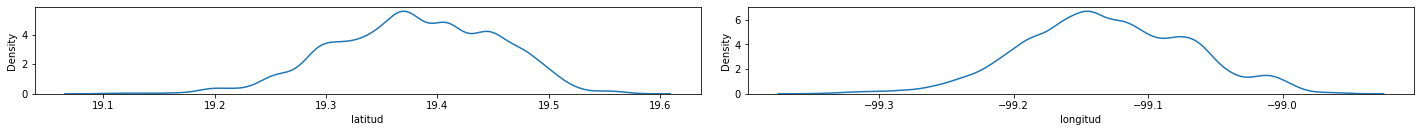

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(30,40))
for i, col in enumerate(incidents.columns):
    if incidents[col].dtype != 'object':
        ax = plt.subplot(21, 3, i+1)
        sns.kdeplot(incidents[col], ax=ax)
        plt.xlabel(col, fontsize=10)
        plt.tight_layout(pad=2.0)
        
plt.show()

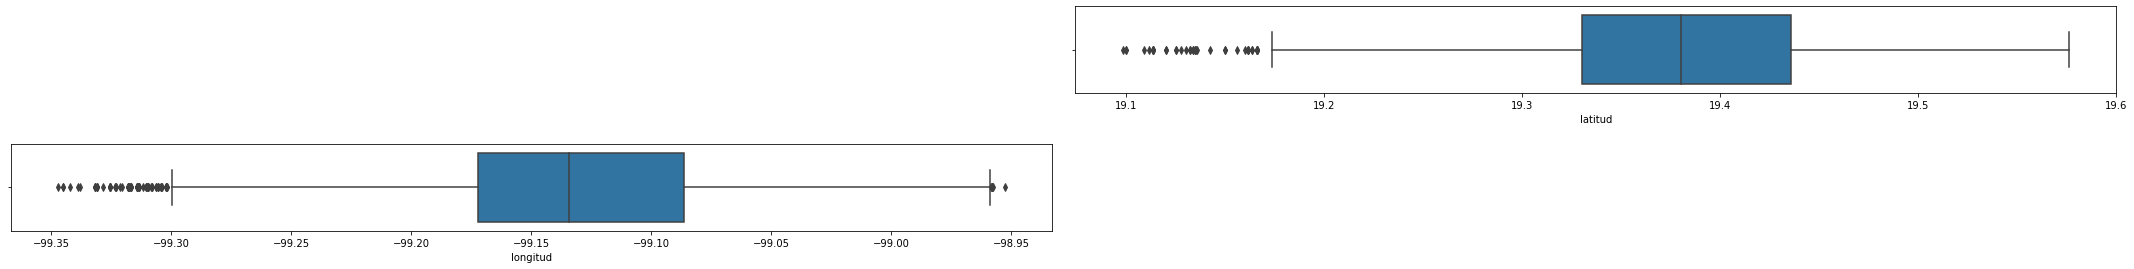

In [19]:
plt.figure(figsize=(30,40))
for i, col in enumerate(incidents.columns):
    if incidents[col].dtype != 'object':
        ax = plt.subplot(21, 2, i+1)
        sns.boxplot(incidents[col], ax=ax)
        plt.xlabel(col, fontsize=10)
        plt.tight_layout(pad=2.0)
        
plt.show()

# Modeling

# Report

# Deployment and consumption

# Useful resources
* https://www.educba.com/predictive-analysis-vs-forecasting/?source=leftnav